# Logistic Regression
Logistic regression is a type of regression that models the probability of a certain class occurring given other independent variables.It uses a logistic or logit function to model a dependent variable. It is a very common predictive model because of its high interpretability.

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
*   Triaxial Angular velocity from the gyroscope
*   A 561-feature vector with time and frequency domain variables
*   The activity label

More information about the features are available on the website linked above.


In [1]:
import seaborn as sns, pandas as pd, numpy as np, warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

The data columns are all floats except for the activity label.


In [3]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities; they are relatively balanced.


In [7]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.\
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

9211    2
5299    2
6632    2
5087    2
4859    5
Name: Activity, dtype: int32

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

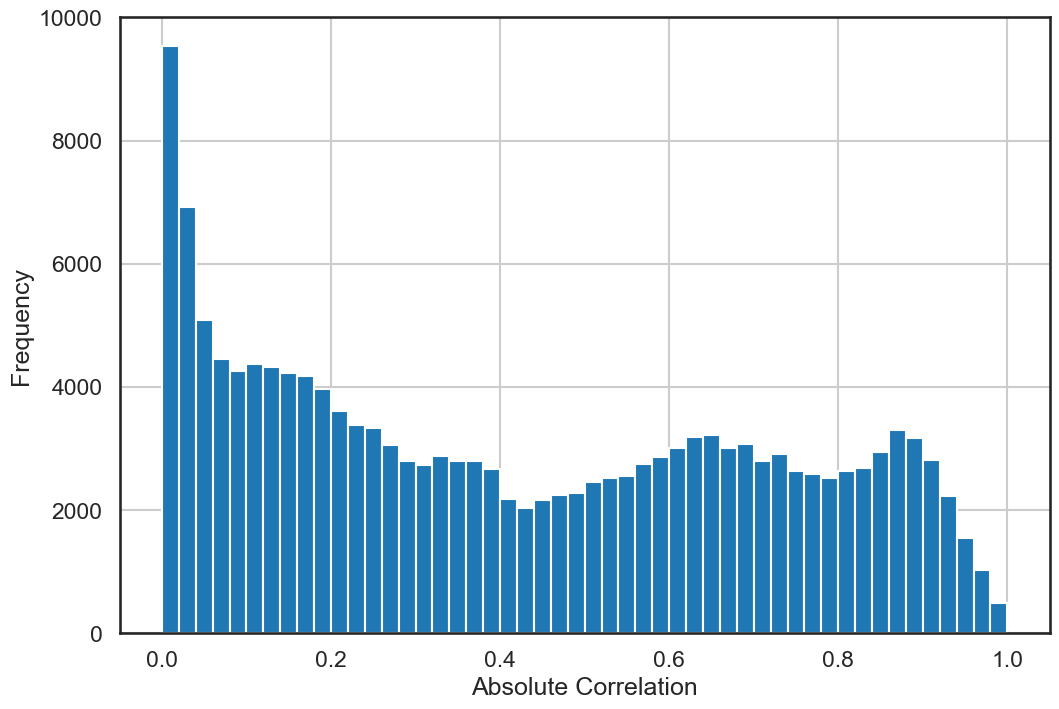

In [11]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


*   Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
*   Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [14]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [18]:
from sklearn.linear_model import LogisticRegressionCV

lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', n_jobs=-1).fit(X_train, y_train)

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear', n_jobs=-1).fit(X_train, y_train)

*   Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.


In [20]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
81  -0.025714 -0.133342  0.071428 -0.080979  0.044290 -0.202523  0.000000   
28   0.098610  0.059819 -0.380409 -0.830662  1.064626 -0.787021  0.000000   
462 -0.007573  0.203949  0.163852 -0.076615 -0.465016  0.737650 -0.031134   
2    0.030187  0.063196  0.245909  0.022340  0.058980 -0.402526  0.000000   
24   0.113946  0.576741 -0.464777  0.196674  1.269542 -1.267064  0.000000   
16   0.024852 -0.086043 -0.022885 -0.649442  0.216938 -0.230367  0.000000   
510 -0.003723 -0.014594  0.053828 -0.067396  0.688315  0.502909  0.000000   
282 -0.036071  0.031882 -0.175761 -0.136028 -0.165344 -0.088916  0.000000   
452  0.378647 -0.409949  0.416460  0.059022 -0.328556 -0.409327  0.511309   
259 -0.020429 -0.005669  0.141121  0.214049 -0.105120 -0.123802  0.000000   

                                                             l2            \
            1         2         3         4         5         0         1   
81   0.000000  0.000000  0.000000  0.000000 -0.644618 -0.050799 -1.785625   
28   0.000000  0.000000 -2.308334  3.992882 -3.849836  0.136814  0.773316   
462  0.003034  0.000000  0.000000 -0.226810  0.567649 -0.033430  0.515081   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.040581 -1.409925   
24   0.509833 -0.317170  0.000000  4.259864 -3.954377  0.248981  0.832103   
16   0.000000  0.000000 -0.232979  0.139677 -0.152439  0.031664 -0.229178   
510  0.000000  0.000000  0.000000  0.576449  1.192647  0.044508  0.270256   
282  0.000000  0.000000  0.000000  0.000000 -0.143020 -0.059133  0.431350   
452 -0.366697  0.294085  0.000000  0.000000 -0.912668  0.712996 -0.400636   
259  0.000000  0.000000  0.000000  0.000000  0.000000 -0.045844 -0.348885   

                                             
            2         3         4         5  
81   1.351780 -0.407078 -0.018419 -1.373797  
28  -0.613838 -2.165627  1.974730 -4.076936  
462  0.347769 -0.218819 -0.741093  2.504261  
2    1.610562  0.134530  0.009772 -1.747063  
24  -0.545919  0.510220  2.559213 -4.179488  
16  -0.233634 -1.487245  0.215022 -0.865290  
510  1.223864 -0.270905  1.411056  2.711870  
282 -0.568444 -0.177855 -0.184223 -0.360740  
452  0.431670  0.495707 -0.388241 -1.721326  
259  0.420790  0.306767 -0.133946  0.122668

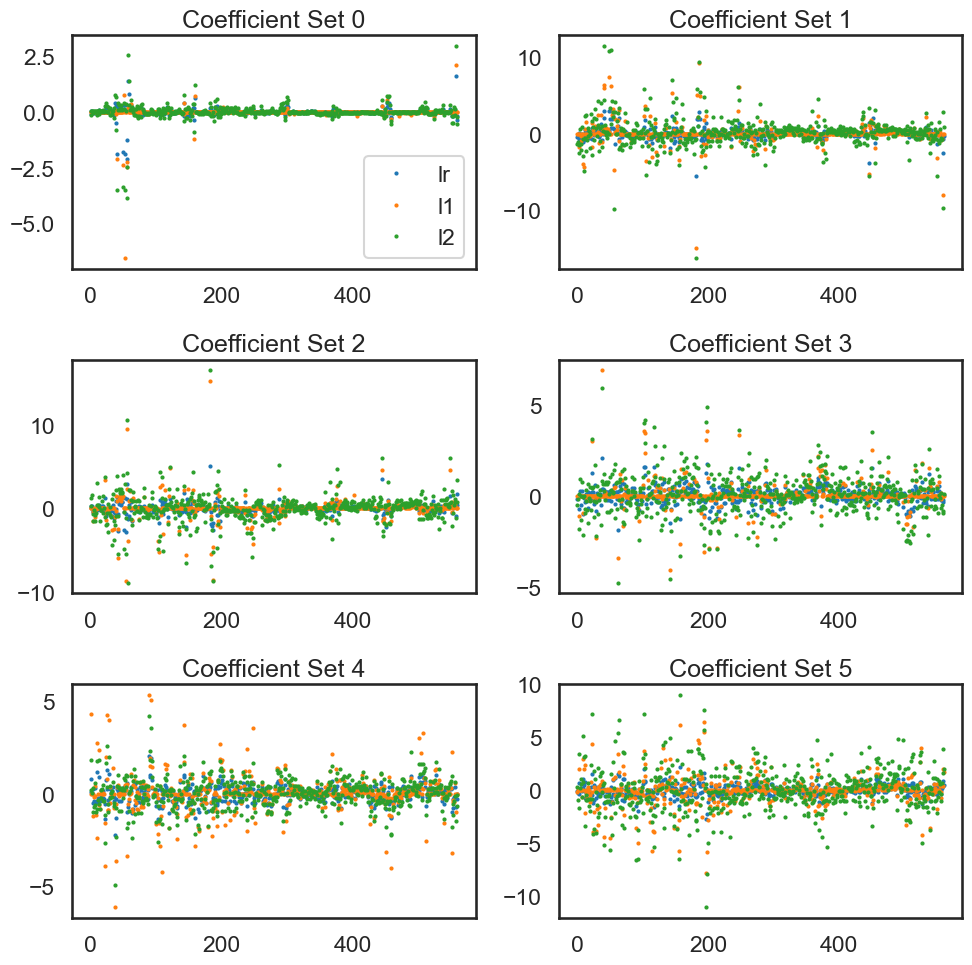

In [21]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

*   Predict and store the class for each model.
*   Store the probability for the predicted class for each model.

In [22]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [23]:
y_prob.head()

,lr,l1,l2
0,0.998939,0.998916,0.999998
1,0.988165,0.999562,0.999477
2,0.987592,0.995327,0.999697
3,0.981381,0.999193,0.999865
4,0.998277,0.999921,0.999997


## Classification Error Metrics

A **confusion matrix** tabulates true positives, false negatives, false positives and true negatives. Remember that the false positive rate is also known as a type I error. The false negatives are also known as a type II error.

**Accuracy** is defined as the ratio of true postives and true negatives divided by the total number of observations. It is a measure related to predicting correctly positive and negative instances.

**Recall or sensitivity** identifies the ratio of true positives divided by the total number of actual positives. It quantifies the percentage of positive instances correctly identified.

**Precision** is the ratio of true positive divided by total of predicted positives. The closer this value is to 1.0, the better job this model does at identifying only positive instances.

**Specificity** is the ratio of true negatives divided by the total number of actual negatives. The closer this value is to 1.0, the better job this model does at avoiding false alarms.

The **receiver operating characteristic (ROC)** plots the true positive rate (sensitivity) of a model vs. its false positive rate (1-sensitivity).

The area under the curve of a ROC plot is a very common method of selecting a classification methods.

The precision-recall curve measures the trade-off between precision and recall.

The ROC curve generally works better for data with balanced classes, while the precision-recall curve generally works better for data with unbalanced classes.  

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [25]:
metrics

,lr,l1,l2
precision,0.984144,0.983844,0.984477
recall,0.984142,0.983819,0.984466
fscore,0.984143,0.983815,0.984464
accuracy,0.984142,0.983819,0.984466
auc,0.990384,0.990145,0.990553


*   Display or plot the confusion matrix for each model.

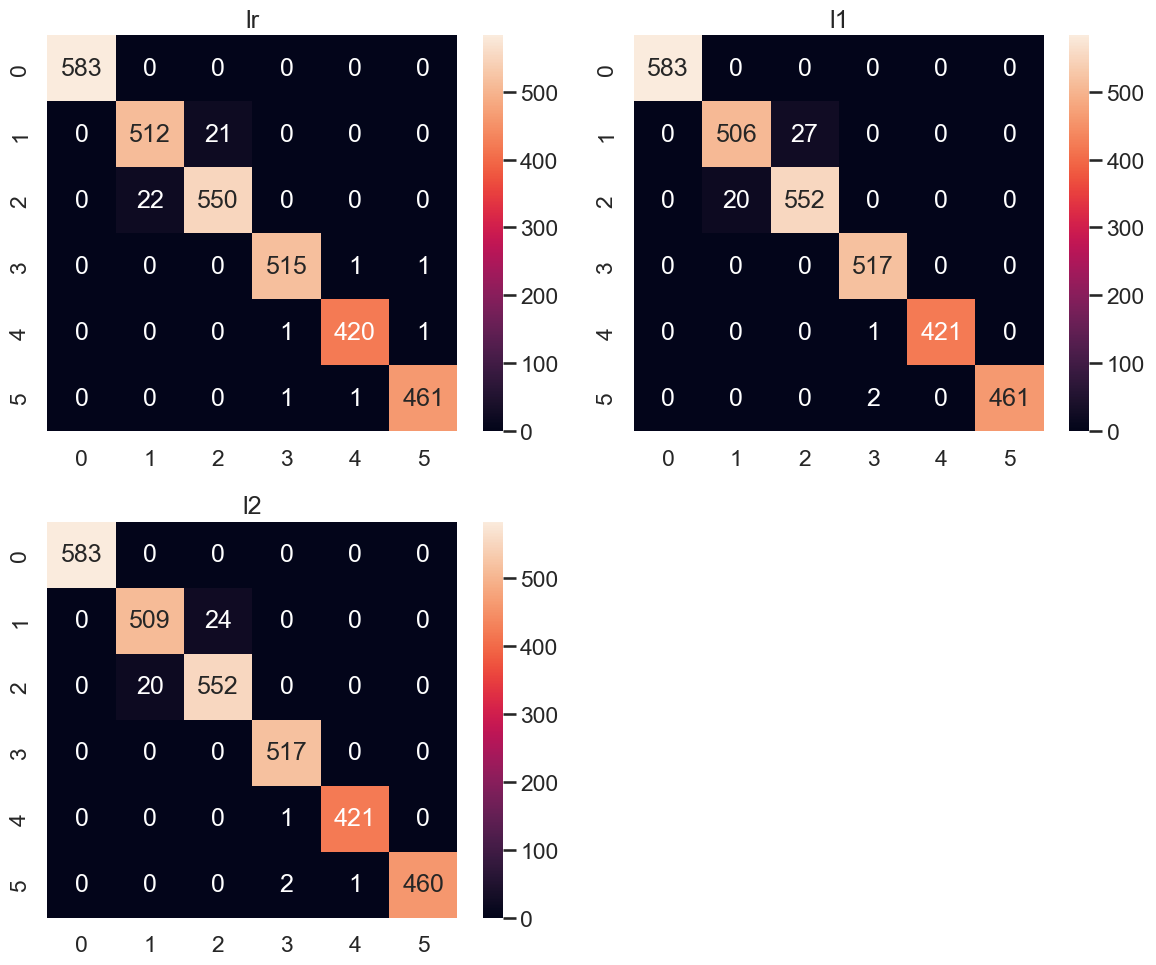

In [26]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()